In [8]:
import cv2
import os
import numpy as np
import warnings
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import vozyaudio as vz

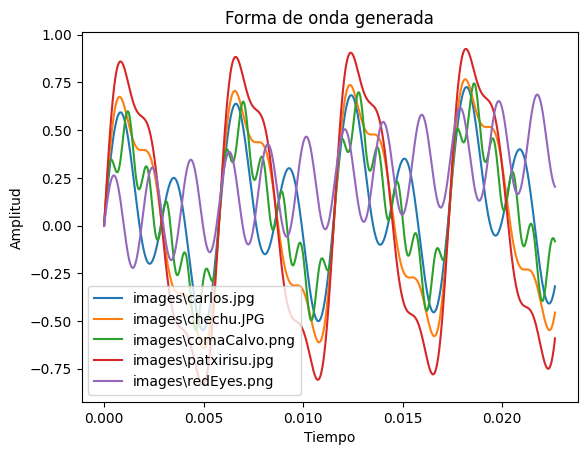

In [9]:
def procesar_imagen_fft(ruta_imagen, fs, num_frecuencias=50, duracion=5):
    """
    Procesa una imagen, extrae sus frecuencias principales y genera un tono

    Args:
        ruta_imagen (str): Ruta de la imagen a procesar
        fs (int): Frecuencia de muestreo para el audio
        num_frecuencias (int): Numero de frecuencias principales a extraer
        duracion (float): Duración total del audio en segundos

    Returns:
        None
    """
    # Se lee y se aplana la imagen, se pasa a escala de grises para que los valores sean de 0 a 255
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.resize(imagen, (256, 256))
    valores_pixeles = imagen.flatten()

    # Se aplica la transformada de fourier para obtener las frecuencias (gracias Victor)
    espectro = np.abs(fft.fft(valores_pixeles))
    freqs = fft.fftfreq(len(valores_pixeles), d=1 / fs)

    # Se eliminan las frecuencias negativas
    freqs = freqs[freqs > 0]
    espectro = espectro[:len(freqs)]

    # Se sacan las frecuencias principales
    indices_principales = np.argsort(espectro)[-num_frecuencias:]
    freqs_principales = freqs[indices_principales]

    # Se genera la señal de audio
    tiempo = np.linspace(0, duracion, int(fs * duracion), endpoint=False)
    audio = np.zeros_like(tiempo)
    for frecuencia in freqs_principales:
        audio += np.sin(2 * np.pi * frecuencia * tiempo)

    # Se normaliza la señal para que no sature
    audio = audio / np.max(np.abs(audio))

    # Reproducir el audio
    vz.sonido(audio, fs)

    # Graficar el tono
    plt.plot(tiempo[:1000], audio[:1000], label=ruta_imagen)
    plt.title("Forma de onda generada")
    plt.xlabel("Tiempo")
    plt.ylabel("Amplitud")
    plt.legend()

fs=44100
# Procesar las imagenes en la carpeta images
for archivo in os.listdir("images"):
    if archivo.endswith(('.png', '.jpg', '.JPG')):
        ruta_imagen_actual = os.path.join("images", archivo)
        procesar_imagen_fft(ruta_imagen_actual, fs, num_frecuencias=10)


Alvaro dice que va a estudiar mas maneras una imagen flow histograma o los canales, todos los efectos de voz que, para que se puedan aplicar a una imagen

Se que hay mucho comentario pero es porque estemos todos en la misma pagina si vemos que todo guay eliminare comentarios q sobran q sino esto parece pacma con lo verde q esta

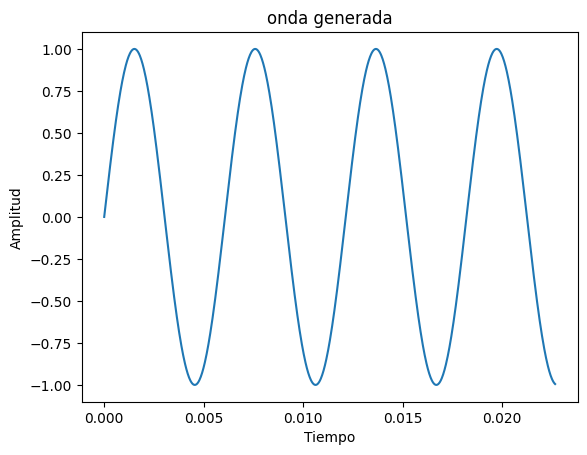

In [11]:
def frecuencia_a_midi(freqs):
    """
    Convierte una lista de frecuencias a notas MIDI enteras y las restringe al rango 60-96

    Args:
        freqs (numpy.ndarray): Array de frecuencias.

    Returns:
        numpy.ndarray: Notas MIDI restringidas al rango 48-96 correspondiente a las notas C2 - C7
    """
    # La formula para convertir de frecuencia a nota MIDI es 69 + 12 * log2(f / 440)
    # https://newt.phys.unsw.edu.au/jw/notes.html
    notas_midi = np.round(69 + 12 * np.log2(freqs / 440)).astype(int)
    return np.clip(notas_midi, 48, 96)


def imagen_a_audio(nombre_archivo, fs, duracion_nota=0.5, duracion_total=5, num_frecuencias=50):
    """
    Procesa una imagen, extrae sus frecuencias principales y genera un tono a partir de ellas

    Args:
        nombre_archivo (str): Ruta de la imagen a procesar
        fs (int): Frecuencia de muestreo para el audio
        duracion_nota (float): Duración de cada nota en segundos
        duracion_total (float): Duración total del audio en segundos
        num_frecuencias (int): Número de frecuencias principales a extraer

    Returns:
        None
    """
    # Leer y procesar la imagen
    imagen = cv2.imread(nombre_archivo, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.resize(imagen, (256, 256))
    valores_pixeles = imagen.flatten()

    # Se calcula el espectro de frecuencias aplicando la transformada de Fourier a los valores de los pixeles
    espectro = np.abs(fft.fft(valores_pixeles))
    # Se calculan las frecuencias correspondientes a cada componente del espectro
    frecuencias = fft.fftfreq(len(valores_pixeles), d=1 / fs)   
    # Se filtran las frecuencias negativas, dejando solo las positivas
    frecuencias = frecuencias[frecuencias > 0]
    # Se ajusta el espectro para que coincida con las frecuencias positivas
    espectro = espectro[:len(frecuencias)]

    # Obtener las frecuencias principales
    # Se seleccionan las N frecuencias con mayor amplitud asi por lo menos se saca algo de la imagen
    # Cuando se vaya a hacer con otro sistema por ejemplo de alvaro se puede revisar y cambiar dependiendo que se le pase
    indices_principales = np.argsort(espectro)[-num_frecuencias:]
    frecuencias_principales = frecuencias[indices_principales]
    notas_midi = frecuencia_a_midi(frecuencias_principales)

    # Ajustar la duracion de las notas
    num_notas = min(len(notas_midi), int(duracion_total / duracion_nota))
    # Crea un array de duraciones con la duracion de la nota que se le pasa
    duraciones = np.full(num_notas, duracion_nota)
    notas_midi = notas_midi[:num_notas]
    # Las funciones de like crean un array con las mismas dimensiones que el array que se le pasa, queda mas limpio imo
    amplitudes = np.ones_like(notas_midi)
    # No tengo muy claro que es pero se necesita para que funcione
    desviaciones = np.zeros_like(notas_midi)

    # Generar el audio
    audio, tiempo = vz.generar_tono_pitchmidi(notas_midi, duraciones, amplitudes, desviaciones, fs)

    # Reproducir y mostrar el resultado
    vz.sonido(audio, fs)
    plt.plot(tiempo[:1000], audio[:1000], label=nombre_archivo)
    plt.title("onda generada")
    plt.xlabel("Tiempo")
    plt.ylabel("Amplitud")
    plt.show()

fs=44100
ruta_imagen = "images/carlos.jpg"
imagen_a_audio(ruta_imagen, fs, duracion_nota=0.1, duracion_total=4)